In [1]:
import findspark
from pyspark.sql import SparkSession
import itertools
import os
from nltk.corpus import stopwords

from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import  Tokenizer, StopWordsRemover,HashingTF, IDF
from pyspark.ml import Pipeline

import numpy as np
import seaborn as sns

from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler 

from pyspark.mllib.linalg import Vectors as MLLibVectors

from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS



In [2]:
findspark.init()
spark = SparkSession.builder.master('local[*]').config("spark.driver.memory", "15g").appName('Project').getOrCreate()

In [3]:
sc = spark.sparkContext

## Load csv data file

In [4]:
dname = 'All_Streaming_Shows.csv'

In [5]:
datapath = os.path.join(os.environ['BIGLAB'], 'datasets')

In [227]:
df = spark.read.csv(os.path.join(datapath, dname), inferSchema = True, header = True, escape='"', maxColumns = 9, multiLine=True)

In [228]:
df.show()

+--------------------+-------------+--------------+-----------+--------+--------------------+--------------------+-------------+--------------------+
|        Series Title|Year Released|Content Rating|IMDB Rating|R Rating|               Genre|         Description|No of Seasons|  Streaming Platform|
+--------------------+-------------+--------------+-----------+--------+--------------------+--------------------+-------------+--------------------+
|        Breaking Bad|         2008|           18+|        9.5|     100|         Crime,Drama|When Walter White...|     5Seasons|             Netflix|
|     Game of Thrones|         2011|           18+|        9.3|      99|Action & Adventur...|Seven noble famil...|     8Seasons|         HBO MAX,HBO|
|      Rick and Morty|         2013|           18+|        9.2|      97|    Animation,Comedy|Rick is a mentall...|     4Seasons|Free Services,HBO...|
|     Stranger Things|         2016|           16+|        8.8|      96|       Drama,Fantasy|When a 

## The project's goal is to predict the show's genre


In [229]:
print(df.select("IMDB Rating").rdd.max()[0])
print(df.select("IMDB Rating").rdd.min()[0])

N/A
1.0


In [230]:
print(df.select("R Rating").rdd.max()[0])
print(df.select("R Rating").rdd.min()[0])

100
-1


In [231]:
df.orderBy(col("R Rating").asc()).show()

+--------------------+-------------+--------------+-----------+--------+------------------+--------------------+-------------+--------------------+
|        Series Title|Year Released|Content Rating|IMDB Rating|R Rating|             Genre|         Description|No of Seasons|  Streaming Platform|
+--------------------+-------------+--------------+-----------+--------+------------------+--------------------+-------------+--------------------+
|  Seasons on the Fly|         2017|           N/A|        N/A|      -1|                -1|                  -1|           -1|                  -1|
|          Max Grundy|         2017|           N/A|        N/A|      -1|                -1|                  -1|           -1|                  -1|
|   Original Specials|         2014|           N/A|        N/A|      -1|                -1|                  -1|           -1|                  -1|
|          Cars, Cars|         2017|           N/A|        N/A|      -1|  2017,Prime Video|Cars, Cars has on...|

#### We can see how we have N/A values, I decided to see how many N/A values have the columns

In [232]:
df = df.replace('N/A',None).replace(-1, None).replace("-1", None)

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()
print((df.count(), len(df.columns)))


+------------+-------------+--------------+-----------+--------+-----+-----------+-------------+------------------+
|Series Title|Year Released|Content Rating|IMDB Rating|R Rating|Genre|Description|No of Seasons|Streaming Platform|
+------------+-------------+--------------+-----------+--------+-----+-----------+-------------+------------------+
|           0|            0|          5121|       2146|     807|  479|        479|          480|              2462|
+------------+-------------+--------------+-----------+--------+-----+-----------+-------------+------------------+

(12353, 9)


## Finding null values


#### I think we can easily drop Content Rating without losing information because it's not something that can be fundamental to identify series genre because like animated series can be strictly for adults or for young people, it's not something that establish the genre.

In [233]:
df = df.drop('Content Rating')

df = df.dropna()
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

print((df.count(), len(df.columns)))

+------------+-------------+-----------+--------+-----+-----------+-------------+------------------+
|Series Title|Year Released|IMDB Rating|R Rating|Genre|Description|No of Seasons|Streaming Platform|
+------------+-------------+-----------+--------+-----+-----------+-------------+------------------+
|           0|            0|          0|       0|    0|          0|            0|                 0|
+------------+-------------+-----------+--------+-----+-----------+-------------+------------------+

(8291, 8)


In [234]:
# I decided to renamed the columns' names in order to have short name or without space
df = df.withColumnRenamed("Series Title","SeriesTitle").withColumnRenamed("Year Released","Year").withColumnRenamed("No of Seasons", "NOSeasons").withColumnRenamed("Streaming Platform", "StreamingPlatform").withColumnRenamed('Content Rating', 'ContentRating').withColumnRenamed('IMDB Rating','IMDBRating').withColumnRenamed('R Rating', 'RRating')

In [235]:
## We have to know what is the column type and correct if it's not correct for the data we have.
df.printSchema()

root
 |-- SeriesTitle: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- IMDBRating: string (nullable = true)
 |-- RRating: integer (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- NOSeasons: string (nullable = true)
 |-- StreamingPlatform: string (nullable = true)



In [236]:
def convertColumn(df, names, newType):
    for name in names: 
        df = df.withColumn(name, df[name].cast(newType))
    return df 

In [237]:
## I decided to remove "Seasons" from the column "No of Seasons"
df = df.withColumn("NOSeasons",regexp_replace("NOSeasons","(\D)",""))

In [238]:
df.show()

+--------------------+----+----------+-------+--------------------+--------------------+---------+--------------------+
|         SeriesTitle|Year|IMDBRating|RRating|               Genre|         Description|NOSeasons|   StreamingPlatform|
+--------------------+----+----------+-------+--------------------+--------------------+---------+--------------------+
|        Breaking Bad|2008|       9.5|    100|         Crime,Drama|When Walter White...|        5|             Netflix|
|     Game of Thrones|2011|       9.3|     99|Action & Adventur...|Seven noble famil...|        8|         HBO MAX,HBO|
|      Rick and Morty|2013|       9.2|     97|    Animation,Comedy|Rick is a mentall...|        4|Free Services,HBO...|
|     Stranger Things|2016|       8.8|     96|       Drama,Fantasy|When a young boy ...|        3|             Netflix|
|            The Boys|2019|       8.7|     95|Action & Adventur...|A group of vigila...|        2|         Prime Video|
|                Dark|2017|       8.8|  

In [239]:
df = convertColumn(df, ["NOSeasons"], IntegerType())


In [240]:
df = df.withColumn("IMDBRating",round(df.IMDBRating.cast(DoubleType()),2))

In [241]:
df.printSchema()


root
 |-- SeriesTitle: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- IMDBRating: double (nullable = true)
 |-- RRating: integer (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- NOSeasons: integer (nullable = true)
 |-- StreamingPlatform: string (nullable = true)



In [242]:
print(df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show())

+-----------+----+----------+-------+-----+-----------+---------+-----------------+
|SeriesTitle|Year|IMDBRating|RRating|Genre|Description|NOSeasons|StreamingPlatform|
+-----------+----+----------+-------+-----+-----------+---------+-----------------+
|          0|   0|         0|      0|    0|          0|        0|                0|
+-----------+----+----------+-------+-----+-----------+---------+-----------------+

None


## Removing numbers from string data 

#### We can see how in Genre have cases with genre followed by the year like "The Office"

In [243]:
df = df.withColumn('Genre', split('Genre', ','))
df = df.withColumn('StreamingPlatform', split('StreamingPlatform', ','))


In [244]:
df = df.withColumn("Genre",expr(f"filter(Genre,x -> x not rlike '^[0-9]*$' )"))


In [245]:
df = df.withColumn("StreamingPlatform", expr("filter(StreamingPlatform, x -> x not rlike '(^[0-9]*$)')"))

df.show()

+--------------------+----+----------+-------+--------------------+--------------------+---------+--------------------+
|         SeriesTitle|Year|IMDBRating|RRating|               Genre|         Description|NOSeasons|   StreamingPlatform|
+--------------------+----+----------+-------+--------------------+--------------------+---------+--------------------+
|        Breaking Bad|2008|       9.5|    100|      [Crime, Drama]|When Walter White...|        5|           [Netflix]|
|     Game of Thrones|2011|       9.3|     99|[Action & Adventu...|Seven noble famil...|        8|      [HBO MAX, HBO]|
|      Rick and Morty|2013|       9.2|     97| [Animation, Comedy]|Rick is a mentall...|        4|[Free Services, H...|
|     Stranger Things|2016|       8.8|     96|    [Drama, Fantasy]|When a young boy ...|        3|           [Netflix]|
|            The Boys|2019|       8.7|     95|[Action & Adventu...|A group of vigila...|        2|       [Prime Video]|
|                Dark|2017|       8.8|  

In [246]:
df.describe('Year', 'IMDBRating', 'RRating', 'NOSeasons').show()

+-------+------------------+------------------+------------------+------------------+
|summary|              Year|        IMDBRating|           RRating|         NOSeasons|
+-------+------------------+------------------+------------------+------------------+
|  count|              8291|              8291|              8291|              8291|
|   mean|2010.3156434688217|7.0125316608370465| 52.34278132915209| 3.316367145097093|
| stddev| 11.40336733668826|1.1253118029473959|14.529765694235213|5.4571824826354245|
|    min|              1922|               1.0|                17|                 1|
|    max|              2020|               9.7|               100|               187|
+-------+------------------+------------------+------------------+------------------+



In [247]:
df_pandas = df.toPandas()

<AxesSubplot:>

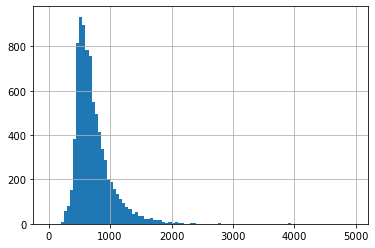

In [248]:
description_length= df_pandas.Description.str.len()
description_length.hist(bins = np.arange(0,5000,50))

<AxesSubplot:xlabel='Year', ylabel='NOSeasons'>

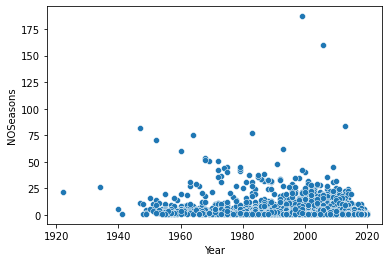

In [249]:
sns.scatterplot(x="Year", y="NOSeasons", data=df_pandas)

<AxesSubplot:xlabel='Year', ylabel='IMDBRating'>

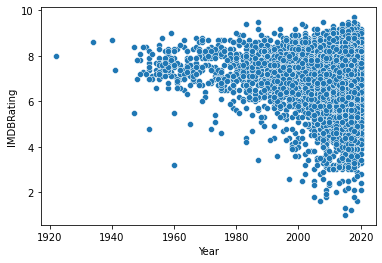

In [250]:
sns.scatterplot(x="Year", y="IMDBRating", data=df_pandas)

<AxesSubplot:xlabel='RRating', ylabel='IMDBRating'>

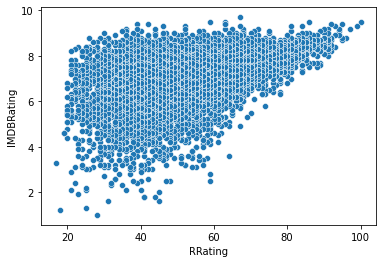

In [251]:
sns.scatterplot(x="RRating", y="IMDBRating", data=df_pandas)

##### I decided to take only serie tv with less than 25 seasons

In [252]:
df = df.filter((col("NOSeasons") <= 25))

##### I decided to take only serie tv released after 1950

In [253]:
df.filter((col("Year") < 1950)).count()

9

In [254]:
df = df.filter((col("Year") > 1950))

In [255]:
df.count()

8209

## Checking Multilabel variables

#### As we see below above, we have "Genre" and "StreamingPlatform" that are array type and we want to see if the string elements are correct and if we can drop elements useless or write wrongly.

In [256]:
df = df.withColumn("Genre",concat_ws(",",col("Genre")))

df = df.withColumn("StreamingPlatform",concat_ws(",",col("StreamingPlatform")))


In [257]:
genre_list = df.select('Genre').rdd.collect()
platform_list = df.select('StreamingPlatform').rdd.collect()
genre = [item.Genre.split(',') for item in genre_list]
platform = [item.StreamingPlatform.split(',') for item in platform_list]

In [258]:
merged_genre = list(set(itertools.chain(*genre)))

In [259]:
len(merged_genre)

47

In [260]:
df.select("Genre").distinct().count()

316

##### As we can read, the column "Genre" has 47 unique values

In [261]:
merged_genre

['Drama',
 'Science',
 'BritBox',
 'Game Show',
 'Sport',
 'Starz',
 'Showtime',
 'Action & Adventure',
 'LGBTQ',
 'Mystery',
 'Prime Video',
 'Horror',
 'Home & Garden',
 'Thriller',
 'Cult',
 'History',
 'Musical',
 'CBS All Access',
 'Hulu',
 'Family',
 'Netflix',
 'AcornTV',
 'Romance',
 'Biography',
 'BET',
 'Animation',
 'Comedy',
 'Anime',
 'DC Universe',
 'Crime',
 'AMC',
 'Children',
 'Viceland',
 'Reality',
 'Fantasy',
 'Free Services',
 'Apple TV+',
 'Food',
 'HBO MAX',
 'fuboTV',
 'Science-Fiction',
 'Documentary',
 'TLC',
 'Travel',
 'Disney+',
 'Hoopla',
 'Stand-up & Talk']

In [262]:
merged_platform = list(set(itertools.chain(*platform)))

In [263]:
len(merged_platform)

64

##### The column "StreamingPlatform" has 64 unique values.

In [264]:
merged_platform

['DIY',
 'Cinemax',
 'MTV',
 'NatGeo',
 'TruTV',
 'Science',
 'BritBox',
 'Syfy',
 'Showtime',
 'Starz',
 'IndieFlix',
 'Funimation',
 'Prime Video',
 'Epix',
 'HBO',
 'Comedy Central',
 'BET+',
 'Peacock Premium',
 'IFC',
 'FYI',
 'History',
 'CBS All Access',
 'Hulu',
 'HGTV',
 'Nick',
 'Netflix',
 'NBC',
 'Hallmark',
 'YouTube Premium',
 'AcornTV',
 'FOX',
 'Sundance',
 'Food Network',
 'BET',
 'Disney',
 'Hallmark Movies Now',
 'CNBC',
 'Bravo',
 'Adult Swim',
 'USA',
 'Travel Channel',
 'DC Universe',
 'Cartoon Network',
 'AMC',
 'ABC',
 'Viceland',
 'TBS',
 'BBC America',
 'Shudder',
 'TVLand',
 'VH1',
 'TNT',
 'AMC Premiere',
 'A&E',
 'Free Services',
 'Apple TV+',
 'Lifetime',
 'HBO MAX',
 'fuboTV',
 'TLC',
 'FX',
 'Disney+',
 'Hoopla',
 'Crunchyroll']

##### We can see that some values from column "StreamingPlatform" were labelled as values in column "Genre"

In [265]:
df_cleaned = df.filter(~df.Genre.isin(merged_platform))


In [266]:
df_support = df_cleaned.withColumn("Genre",concat_ws(",",col("Genre")))
genre_list_2 = df_support.select('Genre').rdd.collect()
genre2 = [item.Genre.split(',') for item in genre_list_2]
merged_genre_cleaned = list(set(itertools.chain(*genre2)))
platform_list_2 = df_support.select('StreamingPlatform').rdd.collect()
platform2 = [item.StreamingPlatform.split(',') for item in platform_list_2]
merged_platform_cleaned = list(set(itertools.chain(*platform2)))

In [267]:
print(len(merged_genre_cleaned))
print(len(merged_platform_cleaned))


27
64


In [268]:
df_cleaned.select("Genre").distinct().count()

295

In [269]:
df_cleaned= df_cleaned.withColumn("Genre", split("Genre", ","))
df_cleaned= df_cleaned.withColumn("StreamingPlatform", split("StreamingPlatform", ","))


In [270]:
df_cleaned.withColumn("explode", explode("Genre")).groupBy("explode").count().orderBy(desc("count")).show(27)

+------------------+-----+
|           explode|count|
+------------------+-----+
|             Drama| 2307|
|            Comedy| 1948|
|         Animation| 1664|
|       Documentary| 1467|
|Action & Adventure| 1421|
|           Reality| 1091|
|             Crime|  903|
|             Anime|  638|
|            Family|  412|
|          Children|  377|
|           Romance|  269|
|           Fantasy|  228|
|   Science-Fiction|  204|
|           History|  188|
|         Game Show|  183|
|           Mystery|  159|
|          Thriller|  147|
|            Horror|  121|
|              Food|  118|
|         Biography|  104|
|     Home & Garden|   94|
|             Sport|   91|
|             LGBTQ|   61|
|            Travel|   40|
|   Stand-up & Talk|   33|
|           Musical|   26|
|              Cult|   10|
+------------------+-----+



In [271]:
df_cleaned= df_cleaned.withColumn("Genre", array_sort("Genre"))
df_cleaned= df_cleaned.withColumn("Genre", array_distinct("Genre"))

In [272]:
df_cleaned.select("Genre").distinct().count()

194

In [273]:
df_cleaned= df_cleaned.withColumn("StreamingPlatform", array_sort("StreamingPlatform"))
df_cleaned= df_cleaned.withColumn("StreamingPlatform",array_distinct("StreamingPlatform"))

In [274]:
df_cleaned.select("StreamingPlatform").distinct().count()

502

### Tokenization of Description column

In [275]:
tokenizer = Tokenizer(inputCol="Description", outputCol="words")
remover = StopWordsRemover()
stopwords = remover.getStopWords() 
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(stopwords)

hashing = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=500)
idf = IDF(inputCol="rawFeatures", outputCol="idf_features")

tf_idf_model_pipeline = Pipeline(stages=[tokenizer, stopwordsRemover,hashing, idf])


In [276]:
sdf_tfidf = tf_idf_model_pipeline.fit(df_cleaned).transform(df_cleaned)


In [277]:
sdf_tfidf.printSchema()

root
 |-- SeriesTitle: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- IMDBRating: double (nullable = true)
 |-- RRating: integer (nullable = true)
 |-- Genre: array (nullable = false)
 |    |-- element: string (containsNull = true)
 |-- Description: string (nullable = true)
 |-- NOSeasons: integer (nullable = true)
 |-- StreamingPlatform: array (nullable = false)
 |    |-- element: string (containsNull = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- rawFeatures: vector (nullable = true)
 |-- idf_features: vector (nullable = true)



In [278]:
sdf_1=sdf_tfidf.drop('Description','words','filtered','rawFeatures')

In [279]:
sdf_1= sdf_1.withColumn("Genre", concat_ws( ',', "Genre"))
sdf_1= sdf_1.withColumn("StreamingPlatform", concat_ws( ',', "StreamingPlatform"))


In [280]:
sdf_1.columns

['SeriesTitle',
 'Year',
 'IMDBRating',
 'RRating',
 'Genre',
 'NOSeasons',
 'StreamingPlatform',
 'idf_features']

In [281]:
genre_platform_indexer = StringIndexer(inputCols=["StreamingPlatform", "SeriesTitle"], outputCols = ["StreamingPlatformNDX", "SeriesTitleNDX"])


In [282]:
sdf_indexed = genre_platform_indexer.fit(sdf_1).transform(sdf_1)

In [283]:
sdf_indexed.show()

+--------------------+----+----------+-------+--------------------+---------+--------------------+--------------------+--------------------+--------------+
|         SeriesTitle|Year|IMDBRating|RRating|               Genre|NOSeasons|   StreamingPlatform|        idf_features|StreamingPlatformNDX|SeriesTitleNDX|
+--------------------+----+----------+-------+--------------------+---------+--------------------+--------------------+--------------------+--------------+
|        Breaking Bad|2008|       9.5|    100|         Crime,Drama|        5|             Netflix|(500,[4,5,17,19,3...|                 0.0|        1108.0|
|     Game of Thrones|2011|       9.3|     99|Action & Adventur...|        8|         HBO,HBO MAX|(500,[4,5,17,19,2...|                 8.0|        2466.0|
|      Rick and Morty|2013|       9.2|     97|    Animation,Comedy|        4|Free Services,HBO...|(500,[4,17,19,24,...|                54.0|        5172.0|
|     Stranger Things|2016|       8.8|     96|       Drama,Fanta

In [284]:
def multi_label_binarizer(df, labels_col ="Genre", genres_col="genres"):
    """
    inputs:
    df: dataframe
    labels_col: StringType() column of Serie's genres
    output_col: ArrayType(FloatType()) column that rapresents genres labelled for each serie
    """

    for i in merged_genre_cleaned:
        df = df.withColumn(i, when(col(labels_col).contains(i), 1).otherwise(0))
        
    df = df.withColumn(genres_col, array(*merged_genre_cleaned))
    
    return df

In [285]:
sdf_indexed = multi_label_binarizer(sdf_indexed)

In [286]:
sdf_indexed = sdf_indexed.drop(*['SeriesTitle','StreamingPlatform', 'Genre'])

In [287]:
assembled_features= VectorAssembler(inputCols = sdf_indexed.columns[:7], outputCol = "features") 
assembled = assembled_features.transform(sdf_indexed.dropna())

### Logistic Regression LBFGS

In [290]:
training_set, test_set = assembled.randomSplit([0.8,0.2], seed=0)


In [293]:
final_result = []
for index in range(0, len(merged_genre_cleaned)):
    def parsePoint(row):
        return LabeledPoint(row.genres[index], MLLibVectors.fromML(row.features))
    labelled_output = training_set.rdd.map(parsePoint)
    modelpred = LogisticRegressionWithLBFGS.train(labelled_output)
    pred = test_set.rdd.map(lambda t: (t.genres[index], modelpred.predict(MLLibVectors.fromML(t.features))))
    final_result.append(pred.collect())
    print(f"Finished processing genere {merged_genre_cleaned[index]}")
    Error_pred = pred.filter(lambda lp: lp[0] != lp[1]).count() / float(test_set.count())
    print(f"Error: {Error_pred:5.4f} for {merged_genre_cleaned[index]}")


Finished processing genere Drama
Error: 0.1436 for Drama
Finished processing genere Game Show
Error: 0.0284 for Game Show
Finished processing genere Sport
Error: 0.0169 for Sport
Finished processing genere Action & Adventure
Error: 0.1038 for Action & Adventure
Finished processing genere LGBTQ
Error: 0.0078 for LGBTQ
Finished processing genere Mystery
Error: 0.0362 for Mystery
Finished processing genere Horror
Error: 0.0241 for Horror
Finished processing genere Home & Garden
Error: 0.0066 for Home & Garden
Finished processing genere Thriller
Error: 0.0302 for Thriller
Finished processing genere Cult
Error: 0.0006 for Cult
Finished processing genere History
Error: 0.0344 for History
Finished processing genere Musical
Error: 0.0066 for Musical
Finished processing genere Family
Error: 0.0634 for Family
Finished processing genere Romance
Error: 0.0477 for Romance
Finished processing genere Biography
Error: 0.0151 for Biography
Finished processing genere Animation
Error: 0.1044 for Animatio

In [114]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LogisticRegressionModel
from pyspark.mllib.evaluation import MultilabelMetrics
import pandas as pd

In [83]:
for i in range(0,len(merged_genre_cleaned)):
    genredatatrain  = training_set.select("features", )
    genredatatrain = genredatatrain.withColumnRenamed(merged_genre_cleaned[i],"label")
    genredatatrain = genredatatrain.withColumn('label',genredatatrain['label'].cast(IntegerType())) 

    lr = LogisticRegression(maxIter=20,featuresCol= 'features', labelCol = 'label')
    lrModel = lr.fit(genredatatrain)
    lrModel.save('Seriesgenre'+'model'+str(i+1))

In [84]:
result =pd.DataFrame()
result['SeriesTitle'] = [int(i.SeriesTitleNDX) for i in test_set.collect()]

In [85]:
for i in range(0,len(merged_genre_cleaned)):
    lrModeltest = LogisticRegressionModel.load('Seriesgenre'+'model'+str(i+1))
    predictions = lrModeltest.transform(test_set)
    predictionvalues = [j.prediction for j in predictions.collect()]
    result[merged_genre_cleaned[i]] = predictionvalues
    

In [86]:
resulTm1 = pd.DataFrame()
resulTm1['SeriesTitle'] = result['SeriesTitle']

In [99]:
for i in range(0,len(merged_genre_cleaned)):
    resulTm1[merged_genre_cleaned[i]] = result[merged_genre_cleaned[i]].apply(lambda x: x)

In [100]:
resulTm1['Predictions'] = result[merged_genre_cleaned].apply(lambda x: list(x.values), axis=1).apply(lambda x: [float(item) for item in x])


In [88]:
resulTm1.to_csv('Predictions.csv',index=False)

In [90]:
scoreAndLabels = []
for i in test_set.select('genres').collect():
    for j in resulTm1['Predictions'].values:
        scoreAndLabels.append((i.genres,j))

In [91]:
scoreAndLabelsParallelized = sc.parallelize(scoreAndLabels)

In [92]:
metrics = MultilabelMetrics(scoreAndLabelsParallelized)

# Summary stats
print("Recall = %s" % metrics.recall())
print("Precision = %s" % metrics.precision())
print("F1 measure = %s" % metrics.f1Measure())
print("Accuracy = %s" % metrics.accuracy)

C:\Users\Lalle\anaconda3\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Recall = 0.9729830589993615
Precision = 0.9729830589993615
F1 measure = 0.9729830589993615
Accuracy = 0.9483865990320073
